In [51]:
from utils import CNNBackbone, ASTBackbone, get_device, SpectrogramDataset, CLASS_MAPPING, torch_train_val_split, \
    Classifier, free_gpu_memory, LSTMBackbone, get_classification_report, test_model
import torch
import umap.umap_ as umap
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, Isomap, SpectralEmbedding
import matplotlib.pyplot as plt
from sklearn.manifold import MDS
import numpy as np
import os
import plotly.express as px

%matplotlib inline

# DATA_PATH = "/home/alex/Downloads/archive(1)/data/"
DATA_PATH = os.path.join(os.getcwd(), "data/")
model_weights_path = os.path.join(os.getcwd(), "model_weights/")
assets_path = os.path.join(os.getcwd(), "assets/")

mel_specs_path = DATA_PATH + "fma_genre_spectrograms/"
beat_mel_specs_path = DATA_PATH + "fma_genre_spectrograms_beat/"
os.makedirs(model_weights_path, exist_ok=True)
os.makedirs(assets_path, exist_ok=True)

EPOCHS = 100
LR = 1e-4
BATCH_SIZE = 8
RANDOM_SEED = 42
RNN_HIDDEN_SIZE = 256
NUM_CATEGORIES = 10
cnn_in_channels = 1
cnn_filters = [32, 64, 128, 256]
cnn_out_feature_size = 256
NUM_LAYERS = 8

if torch.cuda.is_available():
    print(f"Detected GPU: {torch.cuda.get_device_name(0)}")
    print(f"Free GPU Memory: {free_gpu_memory():.2f}%")
else:
    print("CUDA is not available. No compatible GPU detected.")
DEVICE = get_device()

Detected GPU: NVIDIA GeForce RTX 4060 Laptop GPU
Free GPU Memory: 94.80%


In [52]:
def extract_latent_representations(model, dataloader, device, regression_flag):
    model.eval()
    latent_vectors = []
    labels = []
    
    with torch.no_grad():
        for x, y, lengths in dataloader:
            x = x.float().to(device)
            y = y.float().to(device) if regression_flag else y.to(device)
            lengths = lengths.to(device)
            
            # Forward pass
            _, logits = model(x, y, lengths)
            
            # Collect latent vectors and labels
            latent_vectors.append(logits.cpu().numpy())
            labels.append(y.cpu().numpy())
    
    latent_vectors = np.vstack(latent_vectors)
    labels = np.hstack(labels)
    return latent_vectors, labels

def plot_latent_representation(model_name, latent_vectors, labels):
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    fig.suptitle(f"{model_name} Dimensionality Reduction Visualisations", fontsize=16)
    
    # PCA
    pca = PCA(n_components=2)
    reduced_pca = pca.fit_transform(latent_vectors)
    axes[0, 0].scatter(reduced_pca[:, 0], reduced_pca[:, 1], c=labels, cmap='tab10', alpha=0.7)
    axes[0, 0].set_title("PCA")
    axes[0, 0].set_xlabel("Component 1")
    axes[0, 0].set_ylabel("Component 2")
    
    # t-SNE
    tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=42)
    reduced_tsne = tsne.fit_transform(latent_vectors)
    axes[0, 1].scatter(reduced_tsne[:, 0], reduced_tsne[:, 1], c=labels, cmap='tab10', alpha=0.7)
    axes[0, 1].set_title("t-SNE")
    axes[0, 1].set_xlabel("Dimension 1")
    axes[0, 1].set_ylabel("Dimension 2")
    
    # UMAP
    reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2, n_jobs=-1)
    reduced_umap = reducer.fit_transform(latent_vectors)
    axes[0, 2].scatter(reduced_umap[:, 0], reduced_umap[:, 1], c=labels, cmap='tab10', alpha=0.7)
    axes[0, 2].set_title("UMAP")
    axes[0, 2].set_xlabel("Dimension 1")
    axes[0, 2].set_ylabel("Dimension 2")
    
    # Spectral Embedding
    spectral = SpectralEmbedding(n_components=2, affinity='nearest_neighbors', n_neighbors=10)
    reduced_spectral = spectral.fit_transform(latent_vectors)
    axes[1, 0].scatter(reduced_spectral[:, 0], reduced_spectral[:, 1], c=labels, cmap='tab10', alpha=0.7)
    axes[1, 0].set_title("Spectral Embedding")
    axes[1, 0].set_xlabel("Component 1")
    axes[1, 0].set_ylabel("Component 2")
    
    # ISOMAP
    isomap = Isomap(n_neighbors=10, n_components=2)
    reduced_isomap = isomap.fit_transform(latent_vectors)
    axes[1, 1].scatter(reduced_isomap[:, 0], reduced_isomap[:, 1], c=labels, cmap='tab10', alpha=0.7)
    axes[1, 1].set_title("ISOMAP")
    axes[1, 1].set_xlabel("Dimension 1")
    axes[1, 1].set_ylabel("Dimension 2")
    
    # MDS
    mds = MDS(n_components=2, random_state=42, normalized_stress='auto')
    reduced_data = mds.fit_transform(latent_vectors)
    scatter = plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=labels, cmap='tab10', alpha=0.7)
    axes[1, 2].set_title("MDS Visualization")
    axes[1, 2].set_xlabel("Dimension 1")
    axes[1, 2].set_ylabel("Dimension 2")
            
    colorbar_ax = fig.add_axes([0.2, -0.02, 0.62, 0.02])  
    colorbar = fig.colorbar(scatter, cax=colorbar_ax, orientation='horizontal')
    colorbar.set_label("Classes")

    plt.show()


# do t-SNE dimensionality reduction on the latent represantions and visualize them in 3D interactively
def tsne_3d_visualization(model_name, latent_vectors, labels, perplexity=30, n_iter=1000, random_state=42):
    tsne = TSNE(n_components=3, perplexity=perplexity, n_iter=n_iter, random_state=random_state)
    reduced_tsne = tsne.fit_transform(latent_vectors)

    fig = px.scatter_3d(
        x=reduced_tsne[:, 0],
        y=reduced_tsne[:, 1],
        z=reduced_tsne[:, 2],
        color=labels,
        labels={'color': 'Class'},
        title=f"{model_name} Latent Representations t-SNE 3D Visualisation",
        color_continuous_scale=px.colors.sequential.Viridis, 
    )
    fig.update_traces(marker=dict(size=5, opacity=0.7))

    fig.update_layout(
        scene=dict(
            aspectmode='cube', 
            xaxis=dict(
                title="Dimension 1",
                gridcolor="#577B8D",  
                zerolinecolor="#57A6A1",
                backgroundcolor="#344C64", 
            ),
            yaxis=dict(
                title="Dimension 2",
                gridcolor="#577B8D",
                zerolinecolor="#57A6A1",
                backgroundcolor="#344C64",  
            ),
            zaxis=dict(
                title="Dimension 3",
                gridcolor="#577B8D",
                zerolinecolor="#57A6A1",
                backgroundcolor="#344C64",  
            ),
        ),
        paper_bgcolor="black",  
        plot_bgcolor="black",  
        autosize=False, 
        width=800,  
        height=800,  
        margin=dict(l=80, r=80, t=30, b=80), 
    )
    fig.show()

In [53]:
mel_specs_test_data = SpectrogramDataset(mel_specs_path, class_mapping=CLASS_MAPPING, train=False)
mel_specs_test_dl, _ = torch_train_val_split(dataset=mel_specs_test_data, batch_eval=BATCH_SIZE, batch_train=BATCH_SIZE, val_size=.0, shuffle=False)

mel_specs_data = SpectrogramDataset(DATA_PATH + "fma_genre_spectrograms/", class_mapping=CLASS_MAPPING, train=True)
mel_specs_train_dl, mel_specs_val_dl = torch_train_val_split(dataset=mel_specs_data, batch_eval=32, batch_train=32, val_size=.2, shuffle=True)

x_b1, _, _ = next(iter(mel_specs_train_dl))
input_shape = x_b1[0].shape

#### Extract the latent representations of the test data from the best pretrained LSTM model and visualize them using dimensionality reduction techniques

In [54]:
backbone = LSTMBackbone(mel_specs_test_data.feat_dim, rnn_size=RNN_HIDDEN_SIZE, num_layers=NUM_LAYERS, bidirectional=True)
lstm = Classifier(NUM_CATEGORIES, backbone).to(DEVICE)
lstm.load_state_dict(torch.load(model_weights_path+"lstm_genre_mel.pth", weights_only=True))

lstm_latent_vectors, labels = extract_latent_representations(lstm, mel_specs_test_dl, DEVICE, False)

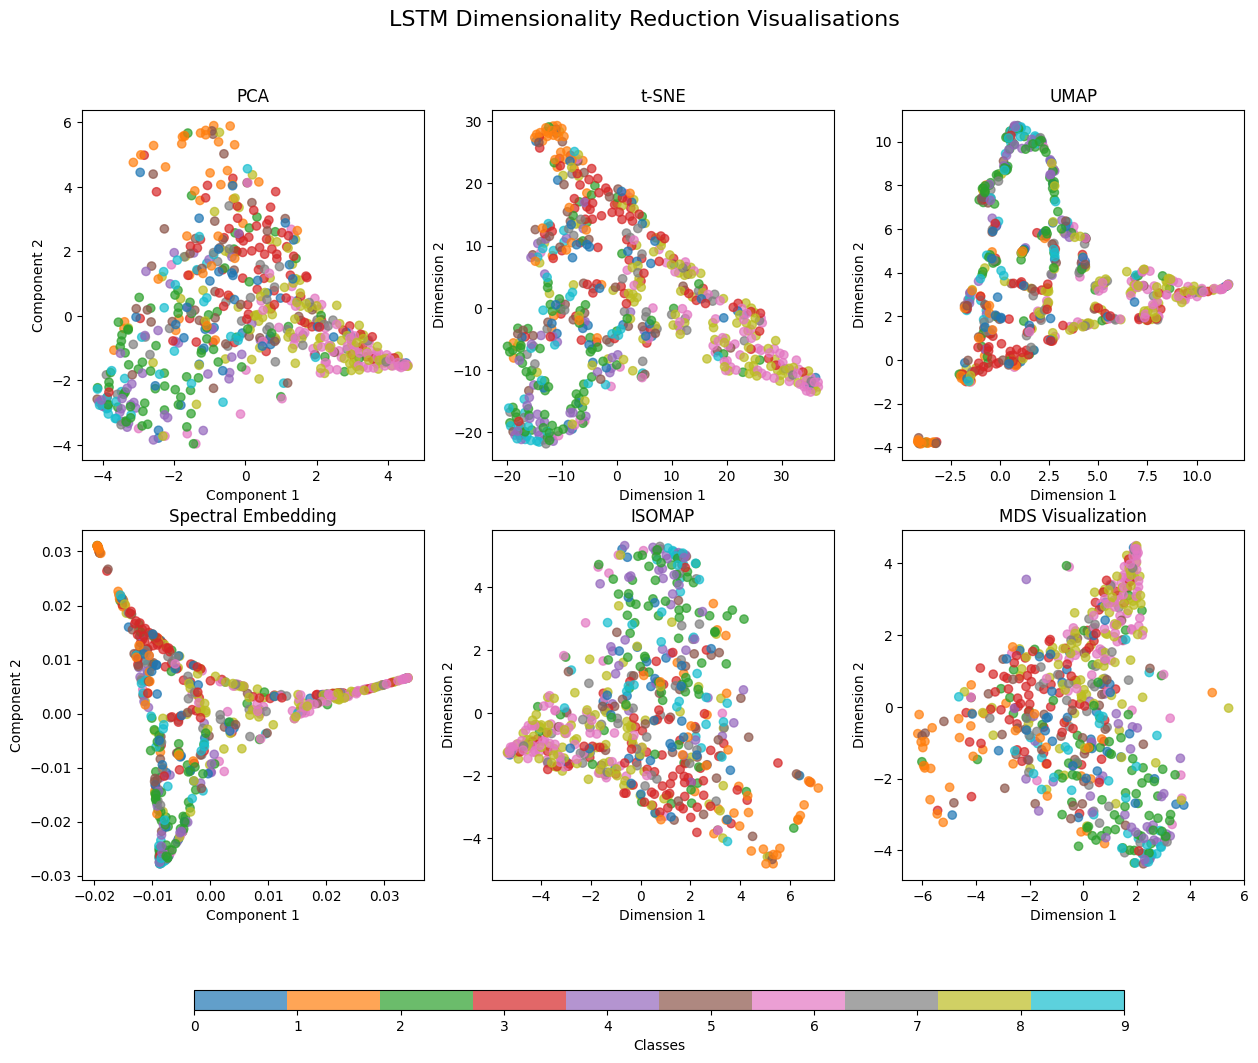

In [5]:
plot_latent_representation("LSTM", lstm_latent_vectors, labels)

In [37]:
tsne_3d_visualization("LSTM", lstm_latent_vectors, labels)

In [55]:
mel_y_true, mel_y_pred = test_model(lstm, mel_specs_test_dl, DEVICE)
get_classification_report(y_pred=np.hstack(mel_y_pred), y_true=np.hstack(mel_y_true))

              precision    recall  f1-score   support

           0        nan      0.00       nan        40
           1       0.50      0.55      0.52        40
           2       0.34      0.56      0.42        80
           3       0.29      0.65      0.40        80
           4       0.00      0.00       nan        40
           5        nan      0.00       nan        40
           6       0.45      0.41      0.43        78
           7        nan      0.00       nan        40
           8       0.31      0.40      0.35       103
           9       0.20      0.06      0.09        34

    accuracy                           0.34       575
   macro avg       0.30      0.26      0.37       575
weighted avg       0.32      0.34      0.38       575

Micro-average precision: 0.34
Micro-average recall: 0.34
Micro-average F1-score: 0.34


#### Extract the latent representations of the test data from the best pretrained CNN model and visualize them using dimensionality reduction techniques

In [56]:
backbone = CNNBackbone(input_dims=input_shape, in_channels=cnn_in_channels, filters=cnn_filters, feature_size=cnn_out_feature_size)

cnn = Classifier(NUM_CATEGORIES, backbone).to(DEVICE)
cnn.load_state_dict(torch.load(model_weights_path+"cnn_genre_mel.pth", weights_only=True))  
cnn_latent_vectors, labels = extract_latent_representations(cnn, mel_specs_test_dl, DEVICE, False)

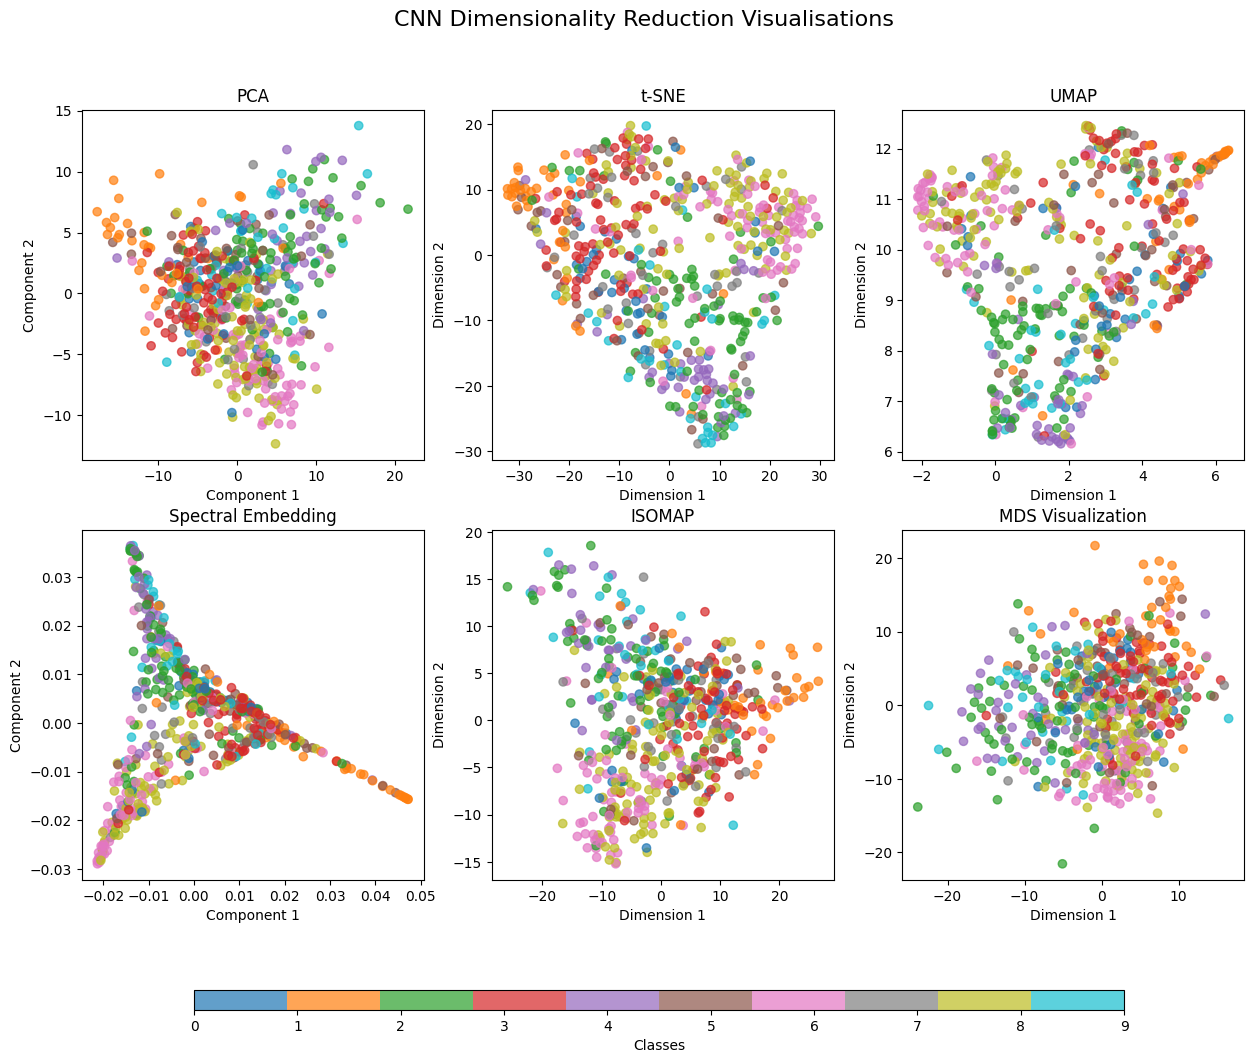

In [57]:
plot_latent_representation("CNN", cnn_latent_vectors, labels)

In [58]:
tsne_3d_visualization("CNN", cnn_latent_vectors, labels)

In [59]:
mel_y_true, mel_y_pred = test_model(cnn, mel_specs_test_dl, DEVICE)
get_classification_report(y_pred=np.hstack(mel_y_pred), y_true=np.hstack(mel_y_true))

              precision    recall  f1-score   support

           0       0.13      0.28      0.17        40
           1       0.45      0.65      0.53        40
           2       0.59      0.60      0.59        80
           3       0.35      0.65      0.46        80
           4       0.59      0.50      0.54        40
           5        nan      0.00       nan        40
           6       0.43      0.73      0.54        78
           7       0.00      0.00       nan        40
           8        nan      0.00       nan       103
           9       0.32      0.21      0.25        34

    accuracy                           0.38       575
   macro avg       0.36      0.36      0.44       575
weighted avg       0.38      0.38      0.47       575

Micro-average precision: 0.38
Micro-average recall: 0.38
Micro-average F1-score: 0.38


#### Extract the latent representations of the test data from the best pretrained AST model and visualize them using dimensionality reduction techniques

In [60]:
backbone = ASTBackbone(
    fstride=10,
    tstride=10,
    input_fdim=input_shape[1],
    input_tdim=input_shape[0],
    imagenet_pretrain=True,
    model_size='tiny224',
    feature_size=NUM_CATEGORIES,
)

ast = Classifier(NUM_CATEGORIES, backbone).to(DEVICE)
ast.load_state_dict(torch.load(model_weights_path+"ast_genre_mel.pth", weights_only=True)) 
ast_latent_vectors, labels = extract_latent_representations(ast, mel_specs_test_dl, DEVICE, False)

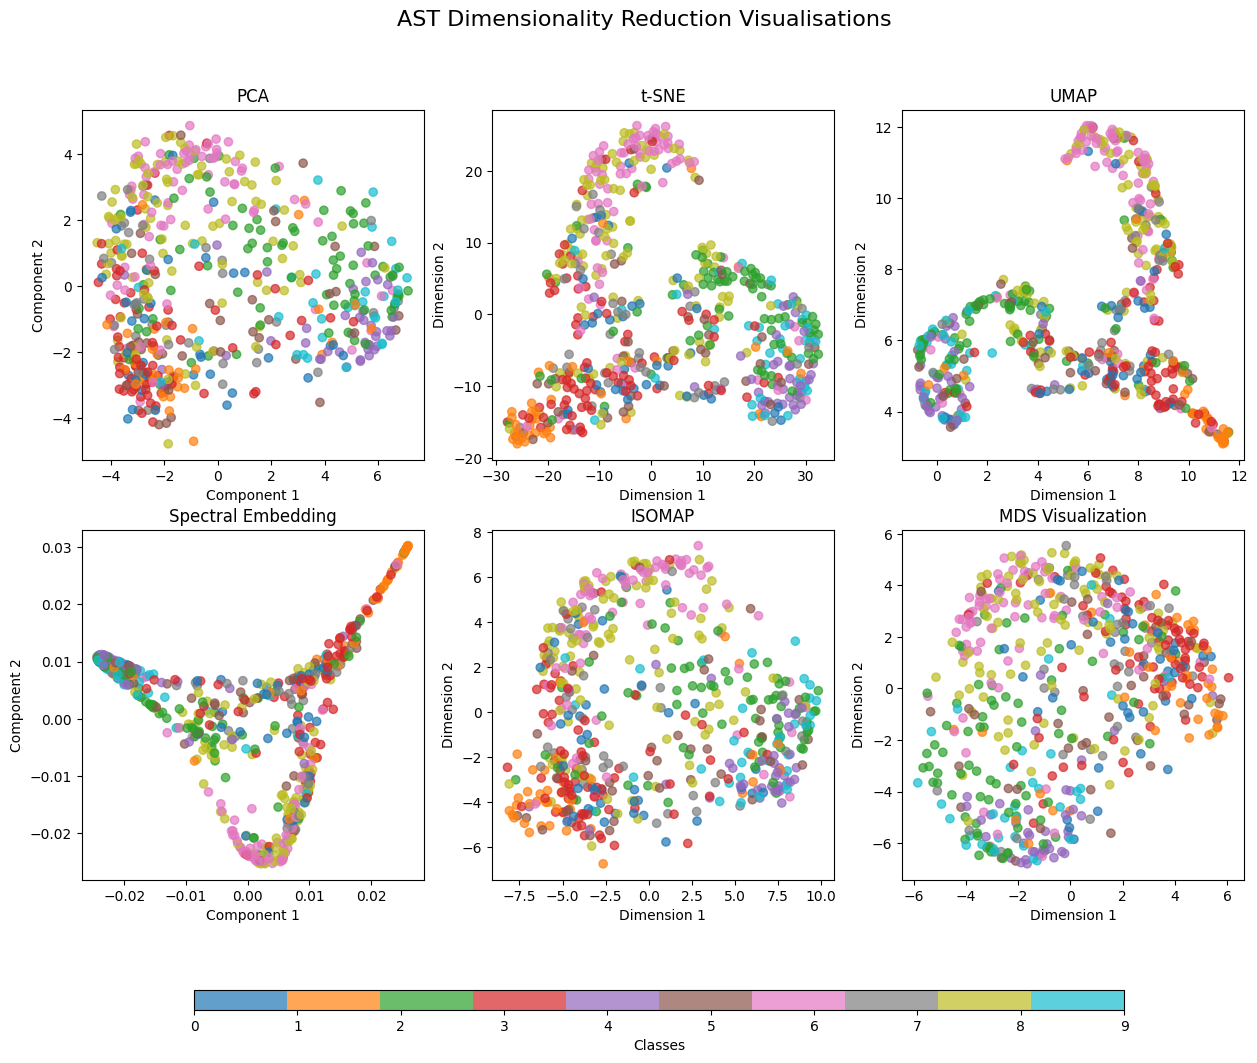

In [61]:
plot_latent_representation("AST", ast_latent_vectors, labels)

In [62]:
tsne_3d_visualization("AST", ast_latent_vectors, labels)

In [63]:
mel_y_true, mel_y_pred = test_model(ast, mel_specs_test_dl, DEVICE)
get_classification_report(y_pred=np.hstack(mel_y_pred), y_true=np.hstack(mel_y_true))

              precision    recall  f1-score   support

           0       0.32      0.15      0.20        40
           1       0.68      0.47      0.56        40
           2       0.45      0.45      0.45        80
           3       0.37      0.74      0.50        80
           4       0.34      0.72      0.46        40
           5       0.20      0.15      0.17        40
           6       0.65      0.47      0.55        78
           7       0.50      0.03      0.05        40
           8       0.45      0.39      0.42       103
           9       0.39      0.32      0.35        34

    accuracy                           0.42       575
   macro avg       0.44      0.39      0.37       575
weighted avg       0.45      0.42      0.40       575

Micro-average precision: 0.42
Micro-average recall: 0.42
Micro-average F1-score: 0.42


In [64]:
del mel_specs_test_data, mel_specs_test_dl

#### Worst model Ever

In [66]:
chroma_test_data = SpectrogramDataset(mel_specs_path, class_mapping=CLASS_MAPPING, train=False, feat_type='chroma', max_length=-1)
chroma_test_dl, _ = torch_train_val_split(dataset=chroma_test_data, batch_eval=32, batch_train=32, val_size=.0, shuffle=False)

In [67]:
backbone = LSTMBackbone(chroma_test_data.feat_dim, rnn_size=RNN_HIDDEN_SIZE, num_layers=NUM_LAYERS, bidirectional=True)
worst_model = Classifier(NUM_CATEGORIES, backbone).to(DEVICE)
worst_model.load_state_dict(torch.load(model_weights_path+"lstm_genre_chroma.pth", weights_only=True, map_location=DEVICE))
worst_latent_vectors, labels = extract_latent_representations(worst_model, chroma_test_dl, DEVICE, False)

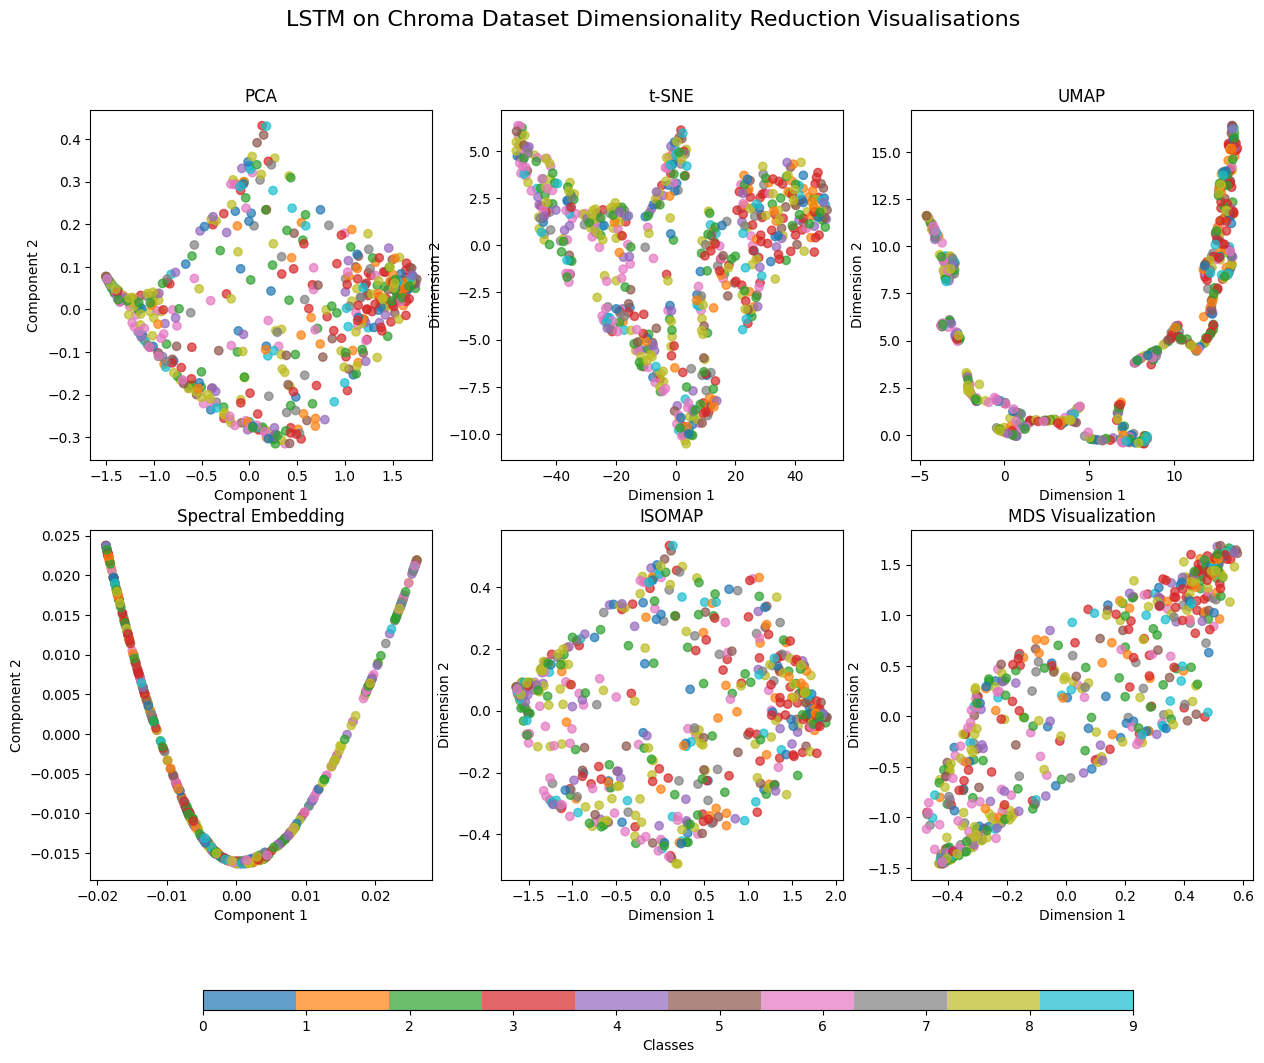

In [68]:
plot_latent_representation("LSTM on Chroma Dataset", worst_latent_vectors, labels)

In [69]:
tsne_3d_visualization("LSTM Chroma", worst_latent_vectors, labels)

In [71]:
chroma_y_true, chroma_y_pred = test_model(worst_model, chroma_test_dl, DEVICE)
get_classification_report(y_pred=np.hstack(chroma_y_pred), y_true=np.hstack(chroma_y_true))

              precision    recall  f1-score   support

           0        nan      0.00       nan        40
           1        nan      0.00       nan        40
           2       0.14      0.07      0.10        80
           3       0.25      0.57      0.35        80
           4        nan      0.00       nan        40
           5        nan      0.00       nan        40
           6       0.26      0.37      0.31        78
           7        nan      0.00       nan        40
           8       0.21      0.50      0.30       103
           9        nan      0.00       nan        34

    accuracy                           0.23       575
   macro avg       0.22      0.15      0.26       575
weighted avg       0.22      0.23      0.27       575

Micro-average precision: 0.23
Micro-average recall: 0.23
Micro-average F1-score: 0.23


In [72]:
del chroma_test_dl, chroma_test_data